In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

In [2]:
np.random.seed(0)
tf.set_random_seed(0)

In [8]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [18]:
#Xavier Initialization of Weights

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [46]:
class VariationalAutoencoder(object):
    
    
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, learning_rate=0.01, batch_size=100):
        
        #initialize values
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
    
        #graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        #create encoder-decoder network
        self._create_network()
        
        #define loss function based on variational upper bound and corresponding optimizer
        self.create_loss_optimizer()
        
        #initialize tensorflow vars
        init = tf.global_variables_initializer()
        
        #launch session
        self.sess = tf.Session()
        self.sess.run(init)
        
        
    def _create_network(self):
        
        #initialize weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)
        
        #Use encoder to determine the mean and log variance of the hidden latent space
        #Since we are constraining the hidden layer to be a gaussian, we will require two parameters
        #These are the mean and the log-vaiance of the latent-space distribution
        #The idea would be to embed similar labels closer together in this lower-dimensional space
        #Thus, letters of the same label will have similar parameters
        self.z_mean, self.z_log_sigma_sq = self._encoder_network(network_weights["encoder_weights"], network_weights["encoder_biases"])
        
        #Draw a Sample from the Error Gaussian Distribution - REPARAMETERIZATION TRICK
        n_z = self.network_architecture["n_z"]
        epsilon = tf.random_normal((self.batch_size, n_z), 0,1, dtype=tf.float32)
        
        #z = mu + sigma(epsilon)
        #while learning sigma, we are actually learning the log of squared std-dev, i.e. log-variance
        #Therefore, we need to apply the inverse of these functions respectively to recover std-dev
        self.z = tf.add(self.z_mean, tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), epsilon))
        
        #Use the Generator Network to get the mean of the Bernoulli of reconstructed input
        #We now reconstruct p(x), which is essentially a Bernoulli because the value of each pixel is either 1 or 0
        #Therefore, the ony parameter we require is the mean
        self.x_reconstruction_mean = self._generator_network(network_weights["generator_weights"], network_weights["generator_biases"])
        

    def _initialize_weights(self, encoder_hidden1, encoder_hidden2, generator_hidden1, generator_hidden2, n_input, n_z):
        
        all_weights = dict()
        
        all_weights["encoder_weights"] = {'h1': tf.Variable(xavier_init(n_input, encoder_hidden1)), 
                                          'h2': tf.Variable(xavier_init(encoder_hidden1, encoder_hidden2)),
                                          'out_mean': tf.Variable(xavier_init(encoder_hidden2, n_z)),
                                          'out_sigma': tf.Variable(xavier_init(encoder_hidden2, n_z))
                                         }
        all_weights["encoder_biases"] = {'b1': tf.Variable(tf.zeros([encoder_hidden1], dtype = tf.float32)), 
                                          'b2': tf.Variable(tf.zeros([encoder_hidden2], dtype = tf.float32)),
                                          'out_mean': tf.Variable(tf.zeros([n_z],  dtype = tf.float32)), 
                                          'out_sigma': tf.Variable(tf.zeros([n_z], dtype = tf.float32))
                                        }
                                                            
        all_weights["generator_weights"] = {'h1': tf.Variable(xavier_init(n_z, generator_hidden1)), 
                                          'h2': tf.Variable(xavier_init(generator_hidden1, generator_hidden2)),
                                          'out_mean': tf.Variable(xavier_init(generator_hidden2, n_input)),
                                          'out_sigma': tf.Variable(xavier_init(generator_hidden2, n_input))
                                         }
        all_weights["generator_biases"] = {'b1': tf.Variable(tf.zeros([generator_hidden1], dtype = tf.float32)), 
                                          'b2': tf.Variable(tf.zeros([generator_hidden2], dtype = tf.float32)),
                                          'out_mean': tf.Variable(tf.zeros([n_input],  dtype = tf.float32)),
                                          'out_sigma': tf.Variable(tf.zeros([n_input], dtype = tf.float32))
                                         }
        return all_weights
        
        
        
    def _encoder_network(self, weights, biases):
        #Map input onto a normal distribution in latent space
        #Trnasformation is parameterized and is learnt
        #Part of the loss is computed by the KL divergence between the learnt distribution Q_lambda(z|x)
        #And the expected/assumed latent space distribution Unit Normal Distribution P(z)
    
        #ESSENTIALLY JUST LEARN THE PARAMETERS OF THE DISTRIBUTION Q_LAMBDA
        #PARAMETERS (MU, SIGMA) WILL BE INDEPENDENT FOR EACH TRAINING EXAMPLE
        #IDEA SEEMS TO BE THAT IMAGES OF THE SAME DIGIT WILL BE MAPPED TO A LATENT SPACE WITH
        #SIMILAR PARAMETERS
 
        ####
            #FOR EACH SAMPLE INPUT, THE PARAMETERS ARE LEARNT FOR EACH UNIT IN THE LATENT SPACE
        ####
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        
        #z_mean and z_log_sigma_sq are the mean and log-var for the latent space gaussians
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])
        z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_sigma']), biases['out_sigma'])
        return(z_mean, z_log_sigma_sq)
                
        
    def _generator_network(self, weights, biases):
        #Maps points in latent space to a Bernoulli distribution in the Data Space
        #Thus only parameter required for stochastic generation/reconstruction of input is mean
        #This mean for the Bernoulli is simply the probability that data=1
        
         ####
            #RECONSTRUCTION_MEAN GIVES IS THE PROBABILITY THAT EACH PIXEL IS ON FOR THE 1*784 VECTOR 
        ####
        
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), biases['b1']))
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']))
        x_reconstruction_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        return x_reconstruction_mean
    
    def create_loss_optimizer(self):
        
        #LOSS COMPRISES TWO TERMS
        
        #1.RECONSTRUCTION LOSS - loss measured between the input and reconstruction
        #This just is the binary cross entropy
        #The prediction is the reconstruction and the original input is the response
        
        #THIS MEASURES THE PIXEL-TO-PIXEL DIFFERENCE IN THE RECONSTRUCTION VS THE INPUT IMAGE
        reconstruction_loss = -tf.reduce_sum(self.x*tf.log(1e-10 + self.x_reconstruction_mean)\
                               +(1-self.x)*tf.log(1e-10 + 1 - self.x_reconstruction_mean))
        
        #2.LATENT LOSS - loss measured between the expected/assumed 
        # unit Gaussian latent representation and the learned (parameterized) latent representation
        latent_loss = -0.5*tf.reduce_sum(1 + self.z_log_sigma_sq - tf.square(self.z_mean) - tf.exp(self.z_log_sigma_sq),1)
        
        self.cost = tf.reduce_mean(reconstruction_loss + latent_loss)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
   
    def partial_fit(self, X):
        #TRAIN
        opt, cost = self.sess.run((self.optimizer, self.cost), feed_dict={self.x:X})
        return cost
    
    def transform(self, X):
        #MAP TO THE HIDDEN LATENT SPACE REPRESENTATION
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        #Generate data by sampling in the latent space and mapping this sample from latent to data space
        #Randomly select the mean for each unit in the hidden latent space
        if z_mu == None: np.random.normal(size=self.network_architecture["n_z"])
        
        #Sample from the Gaussian Distribution
        return self.sess.run(self.x_reconstruction_mean, feed_dict={self.z:z_mu} )
    
    def reconstruct(self, X):
        #Use VAE to reconstruct given data
        return self.sess.run(self.x_reconstruction_mean, feed_dict={self.x: X})

In [47]:
#TRAIN THE VAE
def train(network_architecture, learning_rate=0.001, batch_size=100, training_epochs=10, display_step=5):
    
    #INITIALIZE VAE
    vae = VariationalAutoencoder(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    for epoch in range(training_epochs):
        avg_cost=0
        #MINI-BATCH GRADIENT DESCENT
        total_batch=int(n_samples/batch_size)
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            cost = vae.partial_fit(batch_xs)
            avg_cost += cost/n_samples * batch_size        
        if epoch%display_step == 0:
            print "Epoch: ", '%04d' % (epoch+1), "Cost: ", "{:.9f}".format(avg_cost)
    
    return vae


#DEFINE NETWORK ARCHITECTURE
network_architecture = dict(encoder_hidden1=500, encoder_hidden2=500, generator_hidden1=500, generator_hidden2=500, n_input=784, n_z=20)


#START TRAINING
vae = train(network_architecture, training_epochs=75)           

Epoch:  0001 Cost:  13803.478046875
Epoch:  0006 Cost:  6814.836601562
Epoch:  0011 Cost:  6454.064407848
Epoch:  0016 Cost:  6279.743755327
Epoch:  0021 Cost:  6174.567081854
Epoch:  0026 Cost:  6099.066776456
Epoch:  0031 Cost:  6044.003267933
Epoch:  0036 Cost:  5999.644026989
Epoch:  0041 Cost:  5963.344115767
Epoch:  0046 Cost:  5932.968050426
Epoch:  0051 Cost:  5905.070347124
Epoch:  0056 Cost:  5883.176094638
Epoch:  0061 Cost:  5862.857658913
Epoch:  0066 Cost:  5844.123765980
Epoch:  0071 Cost:  5827.511009411


## Reconstruction

In [52]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

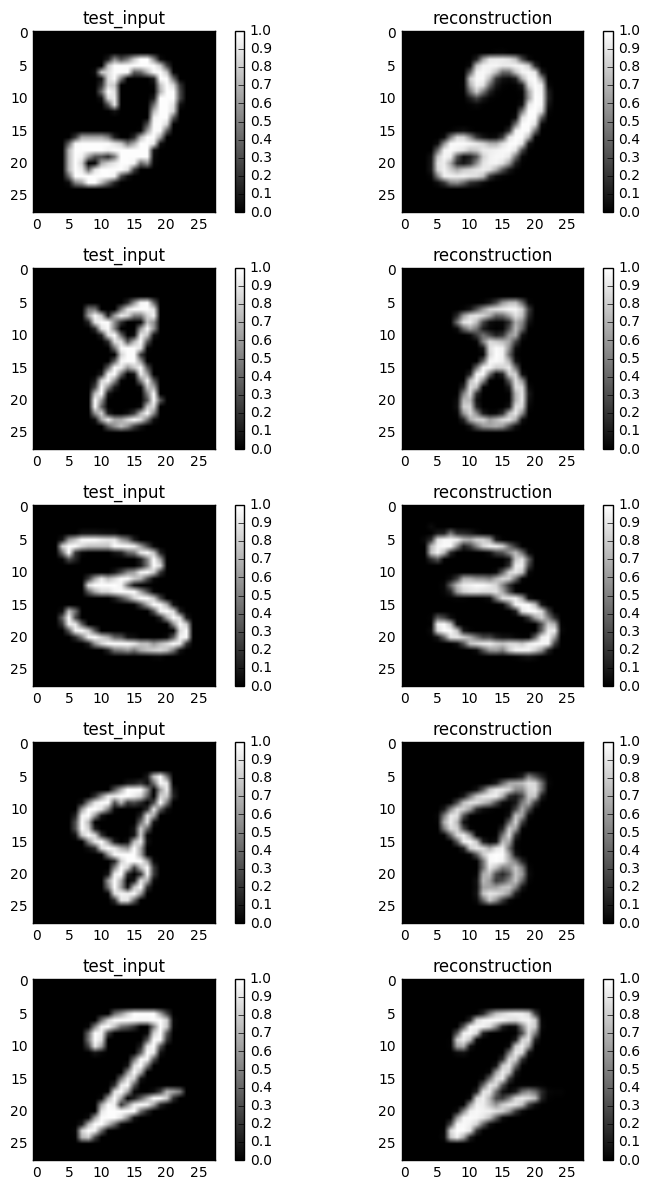

In [56]:
plt.figure(figsize=(8,12))

for i in range(5):    
    #Input
    plt.subplot(5,2,2*i + 1)
    plt.imshow(x_sample[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("test_input")
    plt.colorbar()
    #Reconstruction
    plt.subplot(5,2,2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("reconstruction")
    plt.colorbar()
plt.tight_layout()

## Exploring the Latent Space

Epoch:  0001 Cost:  17472.521610440
Epoch:  0006 Cost:  14253.160715554
Epoch:  0011 Cost:  13694.950587713
Epoch:  0016 Cost:  13427.454888139
Epoch:  0021 Cost:  13265.830147372
Epoch:  0026 Cost:  13150.327425426
Epoch:  0031 Cost:  13042.931905185
Epoch:  0036 Cost:  12954.999229403
Epoch:  0041 Cost:  12890.851949574
Epoch:  0046 Cost:  12857.826115057
Epoch:  0051 Cost:  12799.794090909
Epoch:  0056 Cost:  12745.624346591
Epoch:  0061 Cost:  12707.604021662
Epoch:  0066 Cost:  12670.174618253
Epoch:  0071 Cost:  12637.517086293


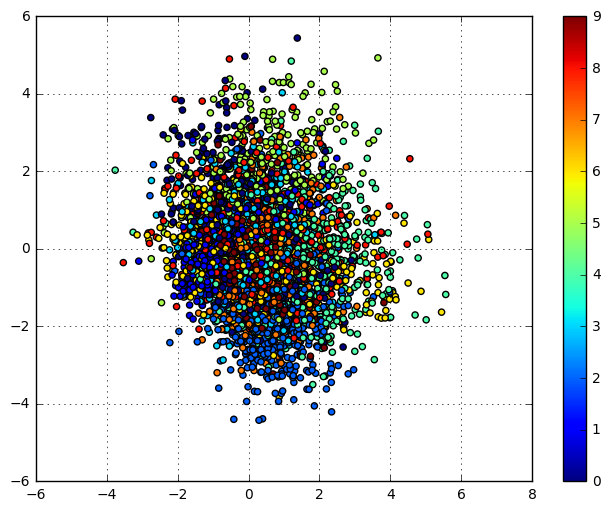

In [58]:
network_architecture = \
    dict(encoder_hidden1=500, # 1st layer encoder neurons
         encoder_hidden2=500, # 2nd layer encoder neurons
         generator_hidden1=500, # 1st layer decoder neurons
         generator_hidden2=500, # 2nd layer decoder neurons
         n_input=784, # MNIST data input (img shape: 28*28)
         n_z=2)  # dimensionality of latent space

vae_2d = train(network_architecture, training_epochs=75)




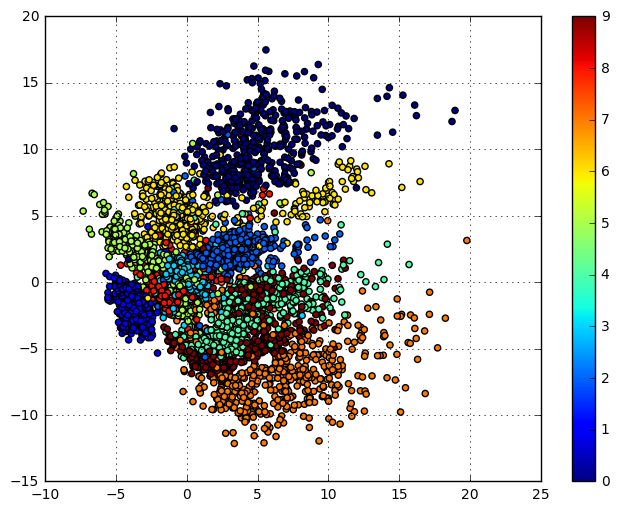

In [59]:

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae_2d.transform(x_sample) #2-dimensional hidden latent space representation
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.grid()

/home/ac07/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:125: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


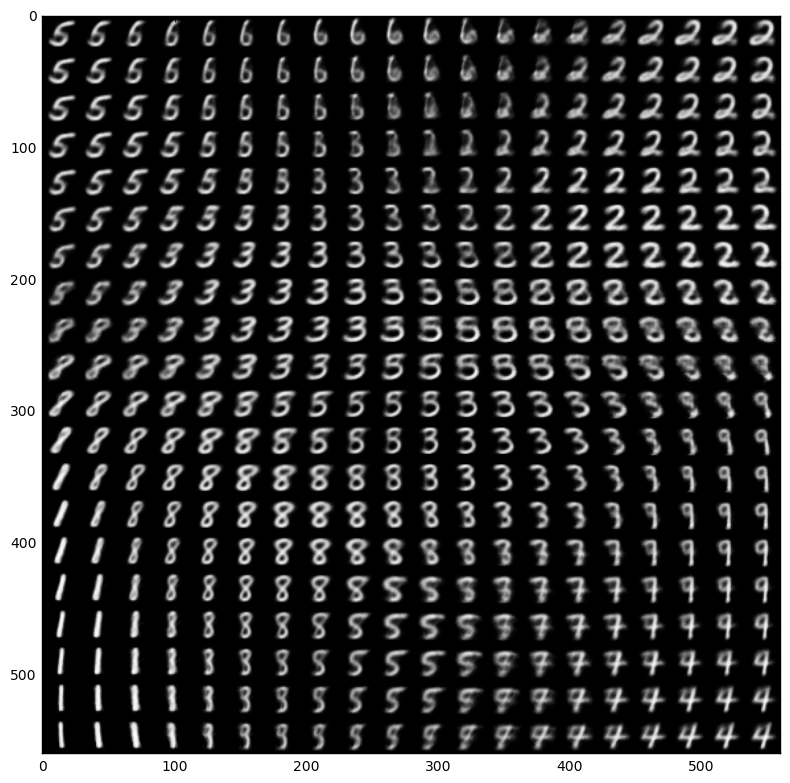

In [83]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)
        
plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

(100, 784) <type 'numpy.ndarray'>
[84] (784,)


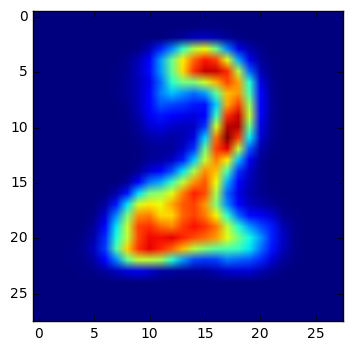

In [120]:
#Explore Generated Samples
import random

#Reconstruct from a randomly parameterized latent space distribution
z_mu = [[1,2]]*100
x_mean = vae_2d.generate(z_mu)


print x_mean.shape, type(x_mean)
samples = random.sample(range(0,99),1) 
print samples, x_mean[r,:].shape
im = x_mean[r,:].reshape(28,28)
plt.imshow(im)